<a href="https://colab.research.google.com/github/henryetta/Tree-Comment-Grower/blob/main/AI_Classifier_for_Tree_Grower_Extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import pipeline, BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())


ImportError: cannot import name 'GenerationMixin' from 'transformers.generation' (/usr/local/lib/python3.12/dist-packages/transformers/generation/__init__.py)

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df = pd.read_csv(r'/content/Trawling for Trolling Dataset.csv', encoding='utf-8')
df = df.sample(frac=1.0, random_state=42)


In [ ]:
# Creating subsets for each category
df_majority = df[df['Category'] == 'Normal']
df_trolling = df[df['Category'] == 'Trolling']
df_profanity = df[df['Category'] == 'Profanity']
df_derogatory = df[df['Category'] == 'Derogatory']
df_hate_speech = df[df['Category'] == 'Hate Speech']
df_micro_aggression = df[df['Category'] == 'Microaggression']

In [ ]:
# Upsampling the minority categories to match the majority (Normal) count
df_trolling_upsampled = resample(df_trolling, replace=True, n_samples=len(df_majority), random_state=123)
df_profanity_upsampled = resample(df_profanity, replace=True, n_samples=len(df_majority), random_state=123)
df_derogatory_upsampled = resample(df_derogatory, replace=True, n_samples=len(df_majority), random_state=123)
df_hate_speech_upsampled = resample(df_hate_speech, replace=True, n_samples=len(df_majority), random_state=123)
df_micro_aggression_upsampled = resample(df_micro_aggression, replace=True, n_samples=len(df_majority), random_state=123)
# Concatenating the upsampled datasets with the majority class
df_balanced = pd.concat([df_majority, df_trolling_upsampled, df_profanity_upsampled, df_derogatory_upsampled, df_hate_speech_upsampled, df_micro_aggression_upsampled])

# Check the new distribution of the balanced dataset
balanced_distribution = df_balanced['Category'].value_counts()
print(balanced_distribution)


Category
Normal             5042
Trolling           5042
Profanity          5042
Derogatory         5042
Hate Speech        5042
Microaggression    5042
Name: count, dtype: int64


In [ ]:
df_balanced = pd.concat([df_majority, df_trolling_upsampled, df_profanity_upsampled, df_derogatory_upsampled, df_hate_speech_upsampled,  df_micro_aggression_upsampled])

<Axes: ylabel='count'>

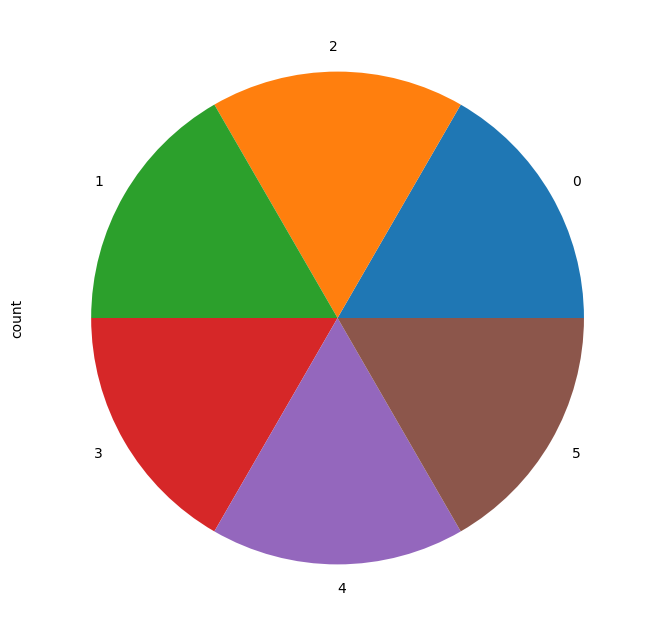

In [ ]:
df_balanced.Label.value_counts().plot(kind='pie', figsize=(8,8))

In [ ]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Get the unique labels from the 'Label' column
labels = df_balanced['Label'].unique().tolist()

# The number of unique labels
NUM_LABELS = len(labels)

# Mapping between labels and IDs
label2id = {'Normal': 0, 'Profanity': 1, 'Trolling': 2, 'Derogatory': 3, 'Hate Speech': 4, 'Microaggression': 5}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
SIZE = df_balanced.shape[0]
train_df = df_balanced[:SIZE//2]
val_df = df_balanced[SIZE//2:3*SIZE//4]
test_df = df_balanced[3*SIZE//4:]

In [ ]:
# Map the numeric labels directly without using .strip()
train_df["labels"] = train_df.Label.map(lambda x: label2id[id2label[x]])
val_df["labels"] = val_df.Label.map(lambda x: label2id[id2label[x]])
test_df["labels"] = test_df.Label.map(lambda x: label2id[id2label[x]])

<ipython-input-11-34ef58a7f635>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["labels"] = train_df.Label.map(lambda x: label2id[id2label[x]])
<ipython-input-11-34ef58a7f635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["labels"] = val_df.Label.map(lambda x: label2id[id2label[x]])
<ipython-input-11-34ef58a7f635>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_df['Comment'] = train_df['Comment'].astype(str)
val_df['Comment'] = val_df['Comment'].astype(str)
test_df['Comment'] = test_df['Comment'].astype(str)


<ipython-input-13-3faec2a86339>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Comment'] = train_df['Comment'].astype(str)
<ipython-input-13-3faec2a86339>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Comment'] = val_df['Comment'].astype(str)
<ipython-input-13-3faec2a86339>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
train_encodings = tokenizer(train_df['Comment'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['Comment'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['Comment'].tolist(), truncation=True, padding=True)


In [ ]:
train_df = train_df.dropna(subset=['Comment'])
val_df = val_df.dropna(subset=['Comment'])
test_df = test_df.dropna(subset=['Comment'])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_df['labels'].tolist())
val_dataset = CustomDataset(val_encodings, val_df['labels'].tolist())
test_dataset = CustomDataset(test_encodings, test_df['labels'].tolist())


In [ ]:
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class Labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _= precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return{
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    run_name="TTC4900Model_run",  # Unique run name to avoid warning
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True,
)

# Ensure all parameters are contiguous
for param in model.parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.591900,1.213376,0.562079,0.568894,0.590463,0.563355
200,1.148500,1.012939,0.623298,0.614405,0.645493,0.626043
300,0.927600,0.888402,0.676187,0.656154,0.659802,0.677017
400,0.823300,0.776216,0.699326,0.689182,0.705232,0.701083
500,0.763600,0.728499,0.742034,0.736893,0.734266,0.742857
600,0.719600,0.742104,0.719159,0.712468,0.742752,0.719374
700,0.718200,0.628554,0.766627,0.769026,0.773671,0.767995
800,0.658100,0.614873,0.774957,0.778595,0.784992,0.776410
900,0.622900,0.636131,0.778791,0.771225,0.775799,0.779844
1000,0.571100,0.655082,0.759884,0.763838,0.794165,0.760878


TrainOutput(global_step=2838, training_loss=0.5327054029455313, metrics={'train_runtime': 2904.7369, 'train_samples_per_second': 15.622, 'train_steps_per_second': 0.977, 'total_flos': 1.1939882268266496e+16, 'train_loss': 0.5327054029455313, 'epoch': 3.0})

In [ ]:
q = [trainer.evaluate(eval_dataset=dataset) for dataset in [train_dataset, val_dataset, test_dataset]]

# Results
pd.DataFrame(q, index=["train", "val", "test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.155193,0.951474,0.951405,0.951586,0.951683
val,0.462548,0.860770,0.860348,0.859968,0.861593
test,0.448629,0.867381,0.864555,0.864258,0.865519


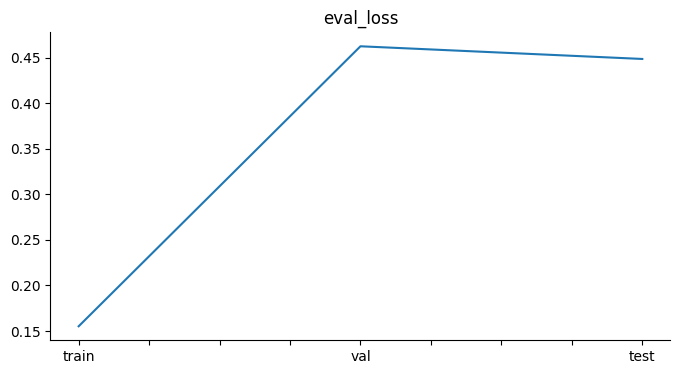

In [ ]:
from matplotlib import pyplot as plt
_df_8 = pd.DataFrame(q, index=["train", "val", "test"]).iloc[:,:5] # Assign the results to _df_8

_df_8['eval_loss'].plot(kind='line', figsize=(8, 4), title='eval_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(Comment):
    inputs = tokenizer(Comment, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Get the model output(logits)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

In [ ]:
model_path = "turkish-text-classification-model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
nlp("That modeling agency is just as greasy as that unwashed head of hair. She better pray her career blows up as big as her hands and Adam's apple.")

[{'label': 'Trolling', 'score': 0.9652326107025146}]

In [ ]:
nlp("you are pretty for a non-white girl")

[{'label': 'Microaggression', 'score': 0.9824134111404419}]

In [ ]:
nlp("youre only employed because you are a girl")

[{'label': 'Microaggression', 'score': 0.9925164580345154}]

In [ ]:
nlp("That modeling agency is just as greasy as that unwashed head of hair. She better pray her career blows up as big as her hands and Adam's apple.")

[{'label': 'Trolling', 'score': 0.9652326107025146}]

In [ ]:
nlp("you can't be gay if you're not white")

[{'label': 'Hate Speech', 'score': 0.9060837626457214}]

In [ ]:
nlp("You're so articulate for someone like you.")

[{'label': 'Microaggression', 'score': 0.9994327425956726}]

In [ ]:
nlp("There are black magazines black award shows black college scholarships and black television channels Since all of these things would be unacceptable for whites it seems that the more privileged race is black. A submission we received that clearly does not get the point of our entire project")

[{'label': 'Microaggression', 'score': 0.9736319184303284}]

In [ ]:
nlp("“When I look at you, I don’t see color.")

[{'label': 'Trolling', 'score': 0.5298528075218201}]

In [ ]:
nlp("A White man or woman clutching their purse or checking their wallet as a Black or Latino approaches or passes. ")

[{'label': 'Hate Speech', 'score': 0.8744293451309204}]

In [ ]:
nlp("Asking a Black person: “Why do you have to be so loud / animated? Just calm down.” ")

[{'label': 'Normal', 'score': 0.945579469203949}]

#save model to drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/turkish-text-classification-model.pth"
torch.save(model.state_dict(), model_path)



In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!zip -r turkish-text-classification-model.zip ./turkish-text-classification-model

  adding: turkish-text-classification-model/ (stored 0%)
  adding: turkish-text-classification-model/model.safetensors (deflated 7%)
  adding: turkish-text-classification-model/training_args.bin (deflated 51%)
  adding: turkish-text-classification-model/tokenizer_config.json (deflated 76%)
  adding: turkish-text-classification-model/special_tokens_map.json (deflated 42%)
  adding: turkish-text-classification-model/vocab.txt (deflated 55%)
  adding: turkish-text-classification-model/tokenizer.json (deflated 71%)
  adding: turkish-text-classification-model/config.json (deflated 52%)


In [ ]:
from google.colab import files
files.download("turkish-text-classification-model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

# Function to predict the category of a given sentence
def predict_category(sentence):
    # Preprocess the input sentence
    inputs = tokenizer(
        [sentence],
        padding=True,
        truncation=True,
        max_length=128,  # Adjust based on  training max_length
        return_tensors='pt'
    )

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        predicted_class = outputs.logits.argmax(dim=1).item()  # Get the predicted class index

    # Map index to category name (adjust based on classes)
    category_names = ['Normal', 'Profanity', 'Trolling', 'Derogatory', 'Hate Speech', 'Microaggression']
    predicted_category = category_names[predicted_class]

    return predicted_category

# Example sentences to test
test_sentences = [
    "I was so tired today, that I decided to skip work and just lay in bed and sleep. Best sleep of my life!",
    "What a fucking psycho! Who in their right fucking mind would pay attention to them. Let's just say that wouldnt be me. Fucking hell!",
    "go eat a penis,homesexual",
    "Youre such a whore of a person",
    "Monkey, go back to your country before I kill you!.",
    "You really speak well for an African. Did you study English when you got here? I also have an African friend from Congo, maybe you know them"
]

# Predict and print the category for each sentence
for sentence in test_sentences:
    result = predict_category(sentence)
    print(f"Sentence: \"{sentence}\" \nPredicted Category: {result}\n")


Sentence: "I was so tired today, that I decided to skip work and just lay in bed and sleep. Best sleep of my life!" 
Predicted Category: Normal

Sentence: "What a fucking psycho! Who in their right fucking mind would pay attention to them. Let's just say that wouldnt be me. Fucking hell!" 
Predicted Category: Profanity

Sentence: "go eat a penis,homesexual" 
Predicted Category: Trolling

Sentence: "Youre such a whore of a person" 
Predicted Category: Microaggression

Sentence: "Monkey, go back to your country before I kill you!." 
Predicted Category: Hate Speech

Sentence: "You really speak well for an African. Did you study English when you got here? I also have an African friend from Congo, maybe you know them" 
Predicted Category: Microaggression

